In [1]:
import os
# import cv2
import timm
import torch
from torch import nn
import torch.nn.functional as F
import itertools
import numpy as np
import pandas as pd
# import albumentations as A
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import neptune
import argparse
import warnings
warnings.filterwarnings("ignore")


import seaborn as sns
import numpy as np
from tqdm import tqdm
from my_models import TransformerRegressionModel
from safety_perception_dataset import *
from collections import Counter

import sys
sys.path.append("/code/LLM-crime")
from custom_clip_train import CLIPModel, CLIPDataset, build_loaders, make_prediction

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, transforms, cfg_paras):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = dataframe['GSV_path']
        self.captions = list(dataframe['text_description_short'])   
        self.encoded_captions = tokenizer(
            self.captions, padding=True, truncation=True, max_length=cfg_paras['max_length']
        )
        self.labels = dataframe['label']
        self.transforms = transforms
        self.img_type = cfg_paras['img_type']
    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        image = self.get_img(idx)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image)
        item['image'] = torch.tensor(image).permute(0, 1, 2).float()
        item['text_description_short'] = self.captions[idx]
        item['label'] = self.labels[idx]
        
        return item

    def get_img(self,idx):
        if self.img_type == 'GSV':
            for i,path in enumerate(self.image_filenames[idx]):
                if i == 0:
                    GSV_img = np.array(Image.open(path))
                else:
                    GSV_img = np.concatenate((GSV_img, np.array(Image.open(path))), axis=1)

            # visualization
            # plt.imshow(GSV_img)
            # plt.title('GSV from original dataset')
            # plt.axis('off')
            return Image.fromarray(GSV_img)
        elif self.img_type == 'PlacePulse':
            GSV_path = self.image_filenames[idx]
            GSV_img = np.array(Image.open(GSV_path))
            return Image.fromarray(GSV_img)

    def __len__(self):
        return len(self.captions)


def get_transforms(cfg_paras, mode="train"):
    if mode == "train":
        return transforms.Compose(
            [
                transforms.Resize(cfg_paras['size']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    else:
        return transforms.Compose(
            [
                transforms.Resize(cfg_paras['size']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )    


def build_loaders(dataframe, tokenizer, mode, cfg_paras):
    transforms = get_transforms(mode=mode, cfg_paras=cfg_paras)
    dataset = CLIPDataset(
        dataframe=dataframe,
        tokenizer=tokenizer,
        transforms=transforms,
        cfg_paras=cfg_paras
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg_paras['batch_size'],
        num_workers=cfg_paras['num_workers'],
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [3]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        cfg_paras,
        data_type
    ):
        super().__init__()
        if data_type == 'image':
            self.projection = nn.Linear(cfg_paras['image_embedding'], cfg_paras['projection_dim'])
        elif data_type == 'text':
            self.projection = nn.Linear(cfg_paras['text_embedding'], cfg_paras['projection_dim'])
        # self.projection = nn.Linear(cfg_paras['embedding_dim'], cfg_paras['projection_dim'])
        self.gelu = nn.GELU()
        self.fc = nn.Linear(cfg_paras['projection_dim'], cfg_paras['projection_dim'])
        self.dropout = nn.Dropout(cfg_paras['dropout'])
        self.layer_norm = nn.LayerNorm(cfg_paras['projection_dim'])
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x
    
# class ImageEncoder(nn.Module):
#     """
#     Encode images to a fixed size vector
#     """

#     def __init__(
#         self, 
#         cfg_paras
#     ):
#         super().__init__()
        
#         self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
#         self.model.patch_embed.proj = nn.Conv2d(3, 768, kernel_size=(16, 16), stride=(8, 8))  # Adjust for 112x112 input
#         self.feature_extractor = nn.Sequential(*list(self.model.children())[:-1])
#         self.image_projection = ProjectionHead(cfg_paras, data_type='image')
        
#         for p in self.model.parameters():
#             p.requires_grad = cfg_paras['trainable']

#     def forward(self, x):
#         features = self.feature_extractor(x)
#         # return features.view(features.size(0), -1)
#         print(features.shape)
#         img_embeddings = self.image_projection(features.view(features.size(0), -1))
#         return img_embeddings
    
class ImageEncoder(nn.Module):
    def __init__(self, cfg_paras):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Remove the last fully connected layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.image_projection = ProjectionHead(cfg_paras, data_type='image')

    def forward(self, x):
        x = self.model(x) # (batch_size, 2048, 1, 1)
        x = torch.flatten(x, 1)  # Flatten the output tensor
        img_embeddings = self.image_projection(x)
        return img_embeddings

    
class TextEncoder(nn.Module):
    def __init__(self, 
                 cfg_paras
                 ):
        super().__init__()
        if cfg_paras['pretrained']:
            self.model = DistilBertModel.from_pretrained(cfg_paras['text_encoder_model'])
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = cfg_paras['trainable']

        self.text_projection = ProjectionHead(cfg_paras, data_type='text')
        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        # return last_hidden_state[:, self.target_token_idx, :]
        text_embeddings = self.text_projection(last_hidden_state[:, self.target_token_idx, :])
        return text_embeddings

In [4]:
cfg_paras = {
    'debug':False,
    # 'dataset_path':"/data2/cehou/LLM_safety/img_text_data/dataset_baseline_baseline_baseline_baseline_1401.pkl",
    'dataset_path':'/data2/cehou/LLM_safety/img_text_data/baseline/tidyed/dataset_baseline_baseline_baseline_baseline_9030_withlabel.csv',
    'save_model_path':"/data_nas/cehou/LLM_safety/LLM_models/clip_model/test",
    'save_model_name':"model_baseline_test.pt",
    'device':torch.device("cuda:3" if torch.cuda.is_available() else "cpu"),
    'CLIP_train_type': 'train', # train, finetune
    'batch_size':60,
    'num_workers':4,
    'head_lr':1e-3,
    'temperature':0.05,
    'image_encoder_lr':0.000100,
    'text_encoder_lr':0.000045,
    'weight_decay':1e-3,
    'img_type':'PlacePulse',
    'patience':1,
    'factor':0.8,
    'epochs':999,
    'image_embedding':2048,
    'text_embedding':768,
    'max_length':512,
    'size':(224,224),
    
    # models for image and text
    'ml_model':'RandomForest',
    'model_name':'resnet50',
    'text_encoder_model':"distilbert-base-uncased",
    'text_tokenizer': "distilbert-base-uncased",
    'pretrained':True,
    'trainable':True,
    
    # deep learning model parameters
    'projection_dim':256,
    'dropout':0.1,
    'early_stopping_threshold':5,
    
    # safety perception
    # 'CLIP_model_path': "/data2/cehou/LLM_safety/LLM_models/clip_model/test/model_baseline_best.pt",
    'variables_save_paths': f"/data2/cehou/LLM_safety/middle_variables/test",
    'safety_model_save_path' : f"/data2/cehou/LLM_safety/LLM_models/safety_perception_model/",
    'placepulse_datapath': "/data2/cehou/LLM_safety/PlacePulse2.0/image_perception_score.csv",
    'eval_path': "/data2/cehou/LLM_safety/eval/test/",
    'train_type': 'classification',
    'safety_epochs': 200,
    'batch_size_safety': 256,
    'CNN_lr': 1e-2,
    }

In [5]:
data = pd.read_csv(cfg_paras['dataset_path'])
data_nonezero = data[data['label'] != 0]
data_nonezero_idx = data[data['label'] != 0].index
# img_feature_nonezero = img_feature[data_nonezero_idx,:]
data_nonezero = data_nonezero.reset_index(drop=True)
data_nonezero.loc[data_nonezero[data_nonezero['label'] == -1].index,'label'] = 0

In [6]:
df = data_nonezero[data_nonezero['Category'] == 'safety']
tokenizer = DistilBertTokenizer.from_pretrained(cfg_paras['text_tokenizer'])

train_num = int(len(df) * 0.7)
train_loader = build_loaders(df.iloc[:train_num], tokenizer, mode="train", cfg_paras=cfg_paras)
valid_loader = build_loaders(df.iloc[train_num:].reset_index(drop=True), tokenizer, mode="valid", cfg_paras=cfg_paras)

image_encoder = ImageEncoder(cfg_paras).to(cfg_paras['device'])
text_encoder = TextEncoder(cfg_paras).to(cfg_paras['device'])

In [7]:
image_features = []
text_features = []
labels = []
# Set the model to evaluation mode
image_encoder.eval()
text_encoder.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for batch in tqdm(train_loader, total=len(train_loader)):
        batch = {k: v.to(cfg_paras['device']) for k, v in batch.items() if k != "text_description_short"}
        img_feature = image_encoder(batch["image"])
        text_feature = text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        labels.append(batch["label"].cpu().numpy())
        image_features.append(img_feature.cpu().numpy())
        text_features.append(text_feature.cpu().numpy())

# Convert the list of features to a numpy array
image_features = np.concatenate(image_features, axis=0)
text_features = np.concatenate(text_features, axis=0)
labels = np.concatenate(labels, axis=0)

100%|██████████| 66/66 [00:10<00:00,  6.02it/s]


cross attention

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, embed_dim):
        super(CrossAttention, self).__init__()
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, query, key, value):
        Q = self.query_proj(query)
        K = self.key_proj(key)
        V = self.value_proj(value)

        # Compute attention weights
        attn_weights = F.softmax(torch.matmul(Q, K.transpose(-2, -1)) / self.scale, dim=-1)
        
        # Compute weighted sum
        output = torch.matmul(attn_weights, V)
        return output, attn_weights

Mix of Experts


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    """专家网络，用于处理文本或图像特征"""
    def __init__(self, input_dim, output_dim):
        super(Expert, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return F.relu(self.fc(x))

class MoE(nn.Module):
    def __init__(self, text_dim, image_dim, output_dim, num_experts):
        super(MoE, self).__init__()
        
        # 文本和图像的专家网络
        self.text_expert = Expert(text_dim, output_dim)
        self.image_expert = Expert(image_dim, output_dim)
        
        # 门控网络，用于决定每个专家的权重
        self.gate = nn.Linear(text_dim + image_dim, num_experts)  # 门控网络的输入是文本和图像的拼接

    def forward(self, text_features, image_features):
        # 将文本和图像特征拼接
        combined_features = torch.cat((text_features, image_features), dim=-1)  # shape: (batch_size, text_dim + image_dim)
        
        # 计算门控网络的权重
        gate_weights = F.softmax(self.gate(combined_features), dim=-1)  # shape: (batch_size, num_experts)
        
        # 分别通过文本和图像的专家网络处理输入
        text_output = self.text_expert(text_features)  # shape: (batch_size, output_dim)
        image_output = self.image_expert(image_features)  # shape: (batch_size, output_dim)
        
        # 将专家输出堆叠成一个 tensor
        expert_outputs = torch.stack([text_output, image_output], dim=1)  # shape: (batch_size, num_experts, output_dim)
        
        # 通过门控权重进行加权求和
        output = torch.sum(gate_weights.unsqueeze(-1) * expert_outputs, dim=1)  # shape: (batch_size, output_dim)
        
        return output

In [10]:
def data_fusion(image_features, text_features, method):
    
    if method == 'concat':
        output = np.concatenate([image_features, text_features], axis=1)
        output = torch.tensor(output)
        
    elif method == 'cross_attention':
        embed_dim = 256
        query = torch.tensor(text_features)  # Batch=16, Sequence Length=10, Embedding=64
        key = torch.tensor(image_features)
        value = torch.tensor(image_features)

        cross_attn = CrossAttention(embed_dim)
        output, attn_weights = cross_attn(query, key, value)
        output = output
    
    elif method == 'MoE':
        text_dim = 256
        image_dim = 256
        output_dim = 512
        num_experts = 2  # 两个专家：一个处理文本，一个处理图像

        # 创建 MoE 模型
        moe = MoE(text_dim, image_dim, output_dim, num_experts)

        # 通过模型进行前向传播
        output = moe(torch.tensor(text_features), torch.tensor(image_features))

        print("Output shape:", output.shape)  # Expected: (32, output_dim)
        
    return output

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 256
input_dim = img_feature.shape[1] + text_feature.shape[1]
num_classes = 2
lr = 1e-4
num_epochs = 10
fusion_method = 'concat'

# 自定义数据集
class ClassificationDataset(Dataset):
    def __init__(self, fused_feature, labels):
        self.fused_feature = fused_feature
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'fused_feature': self.fused_feature[idx],
            'label': self.labels[idx]
        }

# 数据加载器
train_num = int(len(df) * 0.7)
output = data_fusion(image_features, text_features, method=fusion_method)
train_dataset = ClassificationDataset(output, list(data_nonezero['label'])[:train_num])
valid_dataset = ClassificationDataset(output, list(data_nonezero['label'])[train_num:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)


# 定义分类器头
class ClassifierHead(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim
    ):
        super().__init__()
        self.projection = nn.Linear(input_dim, hidden_dim)
        # self.projection = nn.Linear(cfg_paras['embedding_dim'], cfg_paras['projection_dim'])
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(cfg_paras['dropout'])
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.dropout(x)        
        x = self.layer_norm(x)
        x = self.fc(x)
        return x

# 初始化分类器头
classifier_head = ClassifierHead(input_dim=512, hidden_dim=1024, output_dim=2).to(device)
print(classifier_head)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_head.parameters(), lr=lr)

# 训练循环
for epoch in range(num_epochs):
    classifier_head.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, total=len(train_loader)):
        combined_features = batch['fused_feature'].to(device)
        labels = batch['label'].to(device)
        
        outputs = classifier_head(combined_features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # valid
    classifier_head.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, total=len(valid_loader)):
            combined_features = batch['fused_feature'].to(device)
            labels = batch['label'].to(device)
            
            outputs = classifier_head(combined_features)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.2f}%")
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 保存训练好的模型
# torch.save(classifier_head.state_dict(), os.path.join(cfg_paras['save_model_path'], cfg_paras['save_model_name']))

ClassifierHead(
  (projection): Linear(in_features=512, out_features=1024, bias=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 582.75it/s]


Epoch [1/10], Loss: 0.7915, Valid Loss: 0.7527, Accuracy: 51.52%


100%|██████████| 7/7 [00:00<00:00, 1071.22it/s]


Epoch [2/10], Loss: 0.7205, Valid Loss: 0.7072, Accuracy: 51.28%


100%|██████████| 7/7 [00:00<00:00, 1098.40it/s]


Epoch [3/10], Loss: 0.7031, Valid Loss: 0.6995, Accuracy: 50.57%


100%|██████████| 7/7 [00:00<00:00, 1098.27it/s]


Epoch [4/10], Loss: 0.6962, Valid Loss: 0.7026, Accuracy: 49.73%


100%|██████████| 7/7 [00:00<00:00, 1113.18it/s]


Epoch [5/10], Loss: 0.6967, Valid Loss: 0.6992, Accuracy: 50.39%


100%|██████████| 7/7 [00:00<00:00, 977.53it/s]


Epoch [6/10], Loss: 0.6907, Valid Loss: 0.6995, Accuracy: 50.15%


100%|██████████| 7/7 [00:00<00:00, 941.54it/s]


Epoch [7/10], Loss: 0.6927, Valid Loss: 0.7028, Accuracy: 50.98%


100%|██████████| 7/7 [00:00<00:00, 1053.39it/s]


Epoch [8/10], Loss: 0.6889, Valid Loss: 0.7008, Accuracy: 50.63%


100%|██████████| 7/7 [00:00<00:00, 1092.06it/s]


Epoch [9/10], Loss: 0.6869, Valid Loss: 0.7007, Accuracy: 50.03%


100%|██████████| 7/7 [00:00<00:00, 1096.92it/s]

Epoch [10/10], Loss: 0.6844, Valid Loss: 0.7018, Accuracy: 50.03%


Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       572
           1       0.69      0.67      0.68       603

    accuracy                           0.68      1175
   macro avg       0.68      0.68      0.68      1175
weighted avg       0.68      0.68      0.68      1175

Accuracy: 0.6757446808510639


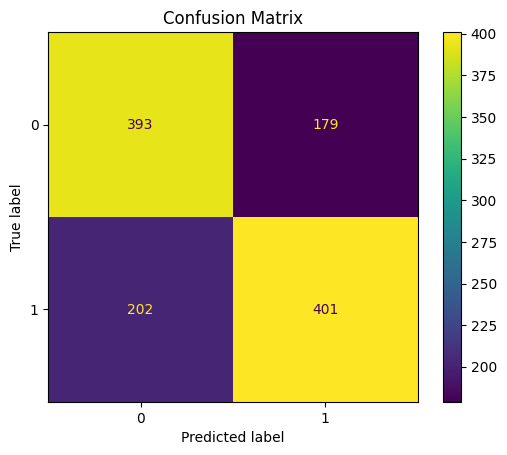

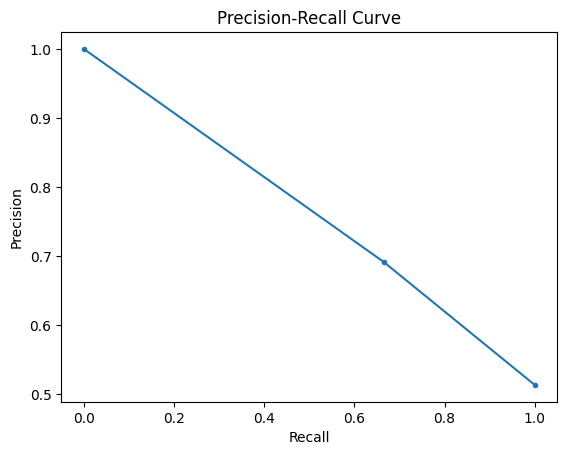

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 准备训练和验证数据
if type(output) == torch.Tensor:
    output = output.detach().numpy()
train_len = int(0.7*len(output))
X_train = output[:train_len]
y_train = labels[:train_len]
X_valid = output[train_len:]
y_valid = labels[train_len:]

# 初始化随机森林分类器
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_valid)

# 打印分类报告和准确率
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy:", accuracy_score(y_valid, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 绘制混淆矩阵
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# 计算precision-recall曲线
precision, recall, _ = precision_recall_curve(y_valid, y_pred)

# 绘制precision-recall曲线
plt.figure()
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [118]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

train_len = int(0.7*len(output))
X_train = output[:train_len]
y_train = labels[:train_len]
X_valid = output[train_len:]
y_valid = labels[train_len:]

# 初始化MLP分类器
mlp_classifier = MLPClassifier(hidden_layer_sizes=(1024,), max_iter=300, random_state=42)

# 训练MLP分类器
mlp_classifier.fit(X_train, y_train)

# 预测验证集
y_pred = mlp_classifier.predict(X_valid)

# 打印分类报告和准确率
print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Accuracy:", accuracy_score(y_valid, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.68       577
           1       0.69      0.70      0.70       598

    accuracy                           0.69      1175
   macro avg       0.69      0.69      0.69      1175
weighted avg       0.69      0.69      0.69      1175

Accuracy: 0.6868085106382978


Text(0.5, 1.0, 'PCA of Fused Feature')

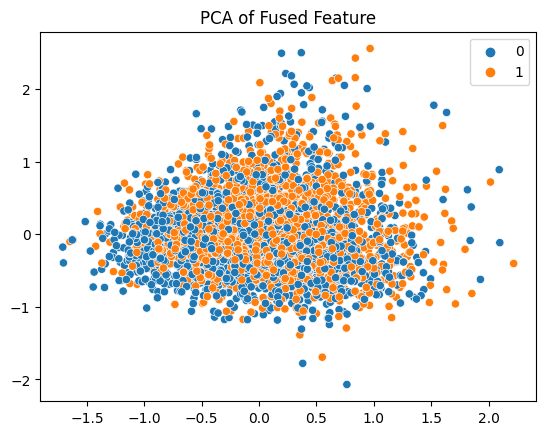

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
combined_feature_pca = pca.fit_transform(output)

sns.scatterplot(x=combined_feature_pca[:,0], y=combined_feature_pca[:,1], hue=labels)
plt.title("PCA of Fused Feature")

In [ ]:
# 使用shap计算每个维度的贡献
import shap

# 使用训练数据创建一个 SHAP explainer
explainer = shap.Explainer(mlp_classifier, X_train)
# explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_valid)

shap_values_overall = shap_values[0] + shap_values[1]
shap_values_sum = shap_values_overall.sum(axis=0).reshape(-1, 1)
print(f"image contribution: {shap_values_sum[:256].sum() / shap_values_sum.sum():.02%}, text contribution: {shap_values_sum[256:].sum() / shap_values_sum.sum():.02%}")

# 绘制 SHAP summary plot
# shap.summary_plot(shap_values, X_valid, feature_names=[f'Feature {i}' for i in range(X_valid.shape[1])])

In [ ]:


# # Example usage
# image_encoder = ImageEncoder(cfg_paras)
# text_encoder = TextEncoder(cfg_paras)
# fusion_model = AttentionalFeatureFusion(image_dim=cfg_paras['image_embedding'], text_dim=cfg_paras['text_embedding'], projection_dim=cfg_paras['projection_dim'])

# # Assuming we have image and text inputs
# image_input = torch.randn(1, 3, 112, 112).to(cfg_paras['device'])
# text_input_ids = torch.tensor([[101, 2054, 2003, 1996, 2171, 102]]).to(cfg_paras['device'])
# text_attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]]).to(cfg_paras['device'])

# image_features = image_encoder(image_input)
# text_features = text_encoder(text_input_ids, text_attention_mask)

# fused_features = fusion_model(image_features, text_features)
# print(fused_features)